In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import random
import pandas as pd

Using TensorFlow backend.


In [ ]:
np.random.seed(0)

In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [ ]:
with open('german-traffic-signs/train.p','rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
    test_data = pickle.load(f)

In [ ]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"

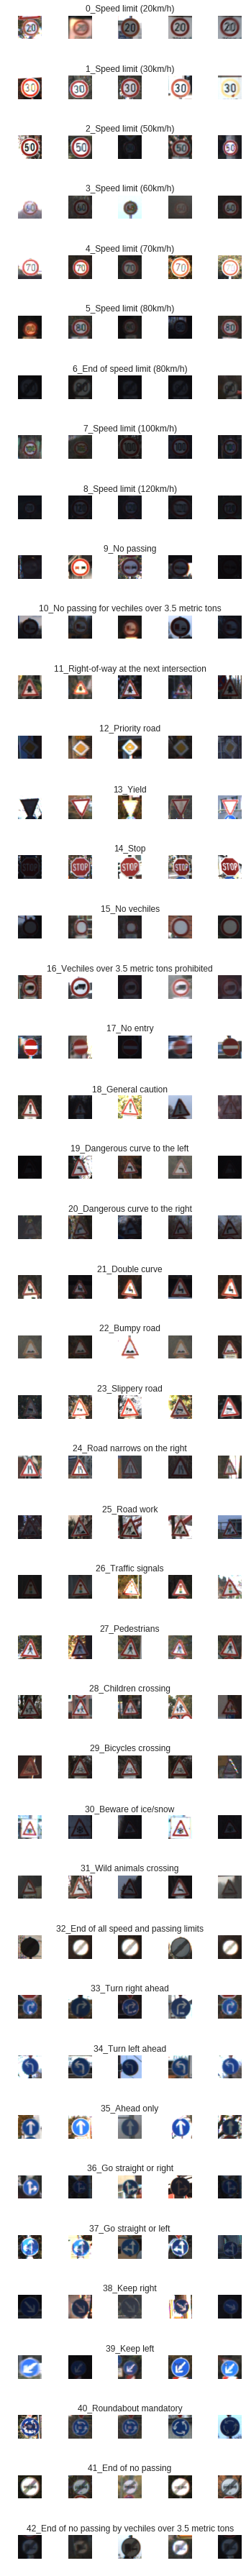

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected)-1)), :, :], cmap = plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "_" + row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

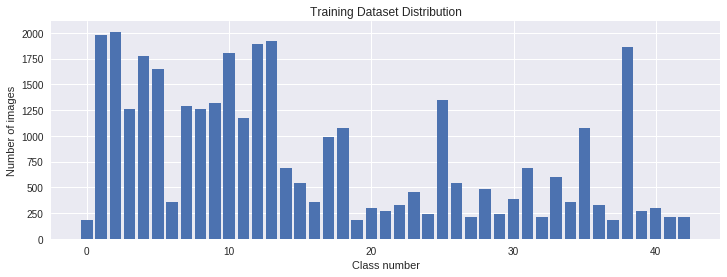

In [ ]:
print(num_of_samples)
plt.figure(figsize = (12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Training Dataset Distribution")
plt.xlabel("Class number")
plt.ylabel("Number of images")


(32, 32, 3)
36


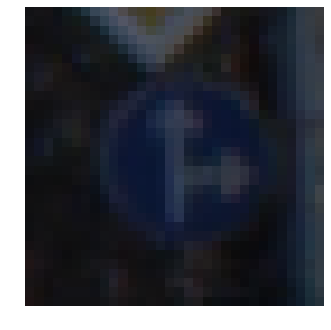

In [ ]:
plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

In [ ]:
def grayscale(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.axis('off')
    return image

(32, 32)


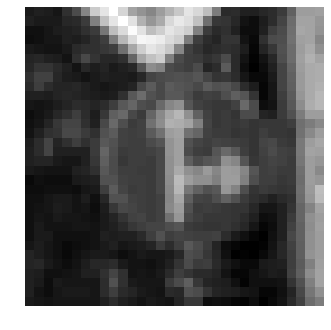

In [ ]:
img = grayscale(X_train[1000])
plt.imshow(img, cmap = 'gray')
print(img.shape)

In [ ]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(32, 32)


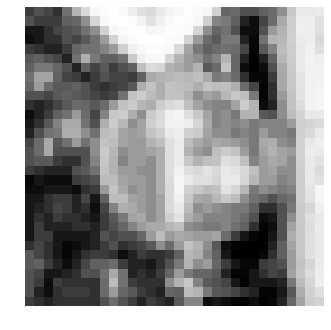

In [ ]:
img = equalize(img)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
print(img.shape)

In [ ]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

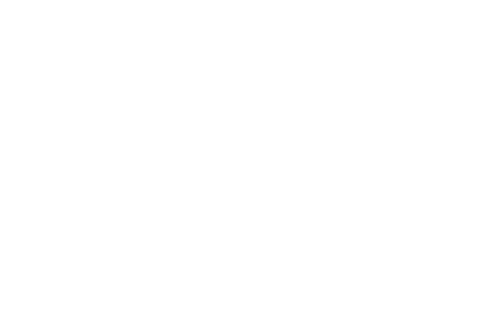

In [ ]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                  height_shift_range = 0.1,
                   zoom_range = 0.2,
                  shear_range = 0.1,
                  rotation_range = 10)

datagen.fit(X_train)

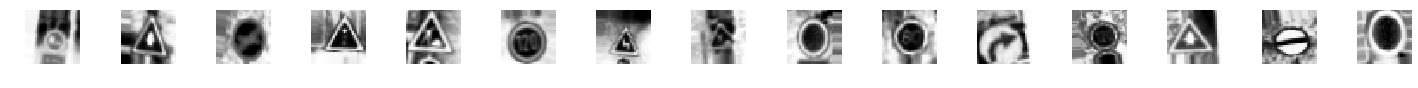

In [ ]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [ ]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [ ]:
def neural_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
    model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Conv2D(30, (3, 3), activation = 'relu'))
    model.add(Conv2D(30, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Flatten())
    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = 'softmax'))
    model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
model = neural_model()
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxP

In [ ]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 50), steps_per_epoch = 2000, epochs = 10, validation_data =(X_val, y_val), shuffle = 1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.9240 - acc: 0.7286 - val_loss: 0.0982 - val_acc: 0.9676
Epoch 2/10
2000/2000 [==============================] - 52s 26ms/step - loss: 0.2261 - acc: 0.9294 - val_loss: 0.0526 - val_acc: 0.9837
Epoch 3/10
2000/2000 [==============================] - 53s 26ms/step - loss: 0.1512 - acc: 0.9525 - val_loss: 0.0466 - val_acc: 0.9868
Epoch 4/10
2000/2000 [==============================] - 52s 26ms/step - loss: 0.1200 - acc: 0.9625 - val_loss: 0.0338 - val_acc: 0.9887
Epoch 5/10
2000/2000 [==============================] - 53s 26ms/step - loss: 0.0994 - acc: 0.9691 - val_loss: 0.0342 - val_acc: 0.9893
Epoch 6/10
2000/2000 [==============================] - 53s 26ms/step - loss: 0.0875 - acc: 0.9730 - val_loss: 0.0278 - val_acc: 0.9923
Epoch 7/10
2000/2000 [==============================] - 52s 26ms/step - loss: 0.0755 - acc: 0.9762 - val_loss: 0.0433 - val_acc: 0.9902


Text(0.5, 0, 'epoch')

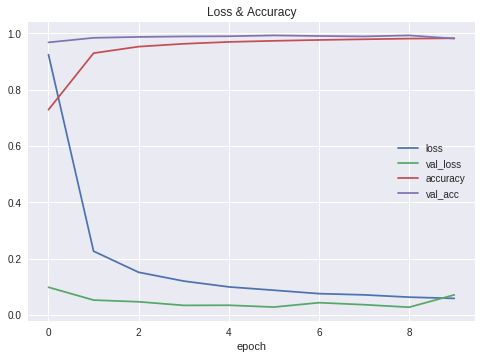

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['loss', 'val_loss', 'accuracy', 'val_acc'])
plt.title('Loss & Accuracy')
plt.xlabel('epoch')

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 1)
print('Test Score', score[0])
print('Test Accuracy', score[1])

12630/12630 [==============================] - 2s 137us/step
Test Score 0.11156745443076539
Test Accuracy 0.9697545526996078


In [ ]:
import requests
from PIL import Image
url = 'https://www.parrs.co.uk/images/no-entry-sign-p5871-7167_image.jpg'
r = requests.get(url, stream=True)
image = Image.open(r.raw)
plt.axis('off')
plt.imshow(image, cmap=plt.get_cmap('gray'))

NameError: ignored

(32, 32)


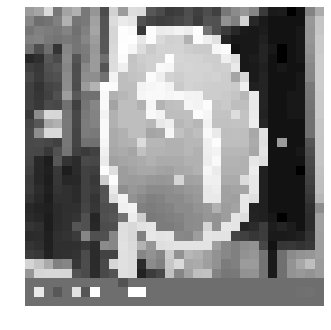

In [ ]:
img = np.asarray(image)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

In [ ]:
prediction = str(model.predict_classes(img))

prediction = prediction[1:-1]

##print("predicted sign: "+ prediction )

predicted sign: 34
predicted sign: Turn left ahead


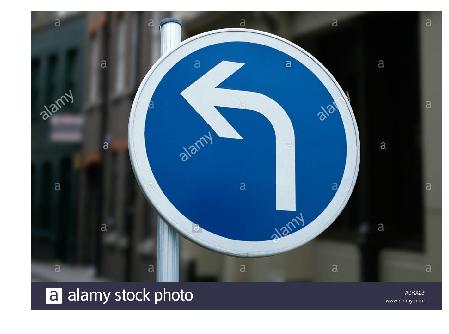

In [ ]:
pred = int(prediction)
plt.imshow(image)
plt.axis('off')

for num, name in data.iteritems():
  name = name.values
  print("predicted sign: "+ str(name[pred]))
